In [7]:
using DelimitedFiles
using Plots
# Construct a structural network from data

# Human Bio grid: 9527 nodes
# Mouse brain: 1029 nodes

edge_list = readdlm("bn_mouse_clean.txt", Int64)
edge_list = edge_list .+ 1
dict_nodes_stru = Dict{Int64, Vector{Int64}}()
dict_edges_stru = Dict{Int64, Vector{Int64}}()
dict_edges_pos = Dict{Int64, Vector{Int64}}()
dict_edges_neg = Dict{Int64, Vector{Int64}}()
M = size(edge_list, 1)
N = maximum(edge_list)

full_list_with_id = zeros(Int64, M, 3)
full_list_with_id[:, 1] = edge_list[:, 1]
full_list_with_id[:, 2] = edge_list[:, 2]
full_list_with_id[:, 3] = collect(N+1: N+M)

for row = 1:M
    dict_edges_stru[full_list_with_id[row, 3]] = [
    full_list_with_id[row, 1], full_list_with_id[row, 2]]
end

for i = 1:N
    dict_nodes_stru[i] = Vector{Int64}()
end

for i = N+1:N+M
    dict_edges_pos[i] = Vector{Int64}()
    dict_edges_neg[i] = Vector{Int64}()
end

for row = 1:M
    node1 = full_list_with_id[row, 1]
    node2 = full_list_with_id[row, 2]
    edge = full_list_with_id[row, 3]

    push!(dict_nodes_stru[node1], edge)
    push!(dict_nodes_stru[node2], edge)
end


In [8]:
include("functions.jl")

function add_poisson_triadic(dict_nodes_stru, dict_edges_stru, cp, cn)

    # Add a regulatory network with Poisson degree distribution on the structural network from real data

    dict_edges_pos = Dict{Int64,Vector{Int64}}()
    dict_edges_neg = Dict{Int64,Vector{Int64}}()

    N = length(dict_nodes_stru)
    M = length(dict_edges_stru)

    for i = N+1:N+M
        dict_edges_pos[i] = Int64[]
        dict_edges_neg[i] = Int64[]
    end

    for edge = N+1:N+M
        for node = 1:N
            if !(node in dict_edges_stru[edge])
                if rand() < cp / N
                    push!(dict_edges_pos[edge], node)
                end
            end
        end
    end

    for edge = N+1:N+M
        for node = 1:N
            if !(node in dict_edges_stru[edge]) & !(node in dict_edges_pos[edge])
                if rand() < cn / N
                    push!(dict_edges_neg[edge], node)
                end
            end
        end
    end
    return dict_edges_pos, dict_edges_neg
end


add_poisson_triadic (generic function with 1 method)

In [9]:
cp = 20     # Average degree of positive regulator
cn = 2      # Average degree of negative regulator
n = 100     # Number of samples taken from the time series to generate the orbit diagram
Tmax = 400  # Duration of the time series
dict_edges_pos, dict_edges_neg = add_poisson_triadic(dict_nodes_stru, dict_edges_stru, cp, cn)


(Dict(1144 => [36, 72, 79, 166, 213, 225, 347, 412, 417, 709, 854, 855, 936, 1014], 2108 => [82, 94, 99, 113, 134, 211, 216, 248, 495, 552  …  638, 667, 677, 707, 711, 755, 875, 903, 913, 1029], 1175 => [93, 138, 266, 323, 499, 502, 554, 609, 668, 714, 805, 835, 840, 929, 1026], 1953 => [97, 124, 275, 386, 408, 474, 481, 510, 531, 538, 594, 611, 723, 775, 839, 906, 970, 986], 2261 => [2, 8, 77, 115, 179, 262, 277, 321, 346, 354  …  574, 583, 677, 744, 751, 771, 773, 797, 848, 868], 1546 => [44, 46, 122, 154, 289, 360, 400, 406, 441, 468, 654, 683, 812, 853, 874, 920, 1008], 1703 => [5, 36, 144, 155, 157, 217, 238, 315, 349, 380  …  657, 750, 791, 814, 827, 836, 953, 967, 981, 994], 1956 => [104, 189, 223, 277, 311, 362, 436, 459, 460, 577, 594, 646, 906, 913, 1004], 2288 => [22, 25, 93, 103, 144, 209, 247, 249, 255, 280  …  684, 726, 729, 747, 789, 808, 830, 867, 902, 1027], 2350 => [40, 42, 113, 210, 372, 391, 408, 433, 503, 522, 549, 578, 603, 634, 649, 762, 888, 903, 940]…), Dict(11

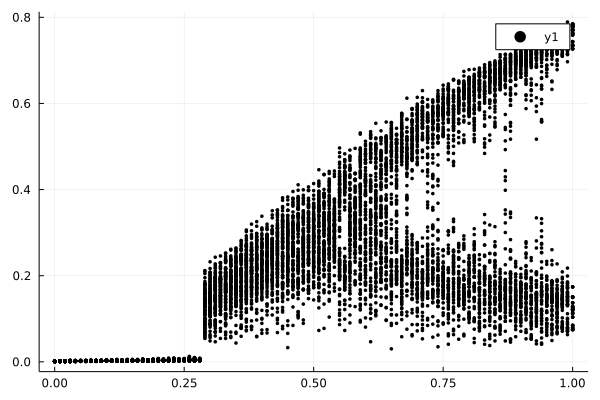

In [10]:
R_collection = Float64[]
p_collection = Float64[]

for p = 1:-0.01:0.0
    # @show p
    retained = [ones(length(dict_nodes_stru)); rand(length(dict_edges_stru)) .< 0.1]
    R, T_list, retained = simulation(dict_nodes_stru, dict_edges_stru, dict_edges_pos, dict_edges_neg, p, retained, Tmax)
    R_collection = [R_collection; R[end-n+1:end]]
    p_collection = [p_collection; p * ones(n)]
end

scatter(p_collection, R_collection, color=:black, markersize=2)
